In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from minisom import MiniSom
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the dataset
tsunami = pd.read_csv(r'C:\Users\ungdu\Downloads\Smart-Decision\Tsunami_Cut.csv')
tsunami.head()

,Year,Mo,Tsunami Event Validity,Tsunami Cause Code,Earthquake Magnitude,Vol,Deposits,Country,Location Name,Latitude,...,Damage ($Mil),Damage Description,Houses Destroyed,Houses Destroyed Description,Total Deaths,Total Death Description,Total Damage ($Mil),Total Damage Description,Total Houses Destroyed,Total Houses Destroyed Description
0,-2000,NaN,1,1.0,NaN,NaN,0,SYRIA,SYRIAN COASTS,35.683,...,NaN,4.0,NaN,NaN,NaN,3.0,NaN,4.0,NaN,NaN
1,-1610,NaN,4,6.0,NaN,1351.0,28,GREECE,THERA ISLAND (SANTORINI),36.400,...,NaN,3.0,NaN,NaN,NaN,3.0,NaN,3.0,NaN,NaN
2,-1365,NaN,1,1.0,NaN,NaN,0,SYRIA,SYRIAN COASTS,35.683,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN
3,-1300,NaN,2,0.0,6.0,NaN,0,TURKEY,"IONIAN COASTS, TROAD",39.960,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-760,NaN,2,0.0,NaN,NaN,0,ISRAEL,ISRAEL AND LEBANON COASTS,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Filter rows where the year is greater than 1800
tsunami_filtered = tsunami[tsunami['Year'] > 1800]


In [4]:
# Filter relevant columns
tsunami_filtered = tsunami_filtered[['Latitude', 'Longitude', 'Tsunami Cause Code']]

In [5]:
# Handle missing values in the filtered columns
tsunami_filtered = tsunami_filtered.dropna()

In [6]:
# Normalize the data
scaler = StandardScaler()
tsunami_normalized = scaler.fit_transform(tsunami_filtered)

In [7]:
# Step 2: Implementing Self-Organizing Maps (SOMs)
som_size = int(len(tsunami_normalized) ** 0.5)
som = MiniSom(som_size, som_size, tsunami_normalized.shape[1], sigma=1.0, learning_rate=0.5)
som.train_random(tsunami_normalized, 100)
def get_winner_coords(data, som):
    return np.array([som.winner(x) for x in data])
som_clusters = get_winner_coords(tsunami_normalized, som)

In [8]:
# Step 3: Implementing Autoencoders
input_dim = tsunami_normalized.shape[1]
encoding_dim = 2
input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation='relu')(input_layer)
decoder = Dense(input_dim, activation='sigmoid')(encoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(tsunami_normalized, tsunami_normalized, epochs=50, batch_size=16, shuffle=True)
encoder_model = Model(inputs=input_layer, outputs=encoder)
encoded_data = encoder_model.predict(tsunami_normalized)

Epoch 1/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.2352 
Epoch 2/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1269
Epoch 3/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step - loss: 1.0511
Epoch 4/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0170
Epoch 5/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0015
Epoch 6/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9717
Epoch 7/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9204
Epoch 8/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9267
Epoch 9/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8590
Epoch 10/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8799
Epoch 11/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8450
Epoch 12/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step - loss: 0.8246
Epoch 13/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step - loss: 0.8284
Epoch 14/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - loss: 0.8305
Epoch 15/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 992u

In [9]:
# Step 4: Clustering using SOMs and Autoencoders
combined_features = np.hstack((encoded_data, som_clusters))
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(combined_features)
tsunami_filtered['Cluster'] = clusters

In [10]:
# Step 5: Visualization on World Map using geopandas and contextily
gdf = gpd.GeoDataFrame(tsunami_filtered, geometry=gpd.points_from_xy(tsunami_filtered.Longitude, tsunami_filtered.Latitude))
gdf.set_crs(epsg=4326, inplace=True)

,Latitude,Longitude,Tsunami Cause Code,Cluster,geometry
611,45.300,14.400,9.0,1,POINT (14.40000 45.30000)
612,17.200,-62.400,1.0,4,POINT (-62.40000 17.20000)
614,10.300,-64.500,1.0,4,POINT (-64.50000 10.30000)
615,-3.700,128.200,1.0,3,POINT (128.20000 -3.70000)
616,45.700,26.600,1.0,4,POINT (26.60000 45.70000)
...,...,...,...,...,...
2856,-14.985,167.983,1.0,3,POINT (167.98300 -14.98500)
2857,8.527,126.449,1.0,3,POINT (126.44900 8.52700)
2858,-20.659,169.206,1.0,3,POINT (169.20600 -20.65900)
2859,37.498,137.242,3.0,0,POINT (137.24200 37.49800)


C:\Users\ungdu\AppData\Local\Temp\ipykernel_1164\2098609292.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
C:\Users\ungdu\AppData\Local\Temp\ipykernel_1164\2098609292.py:3: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  oceans = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


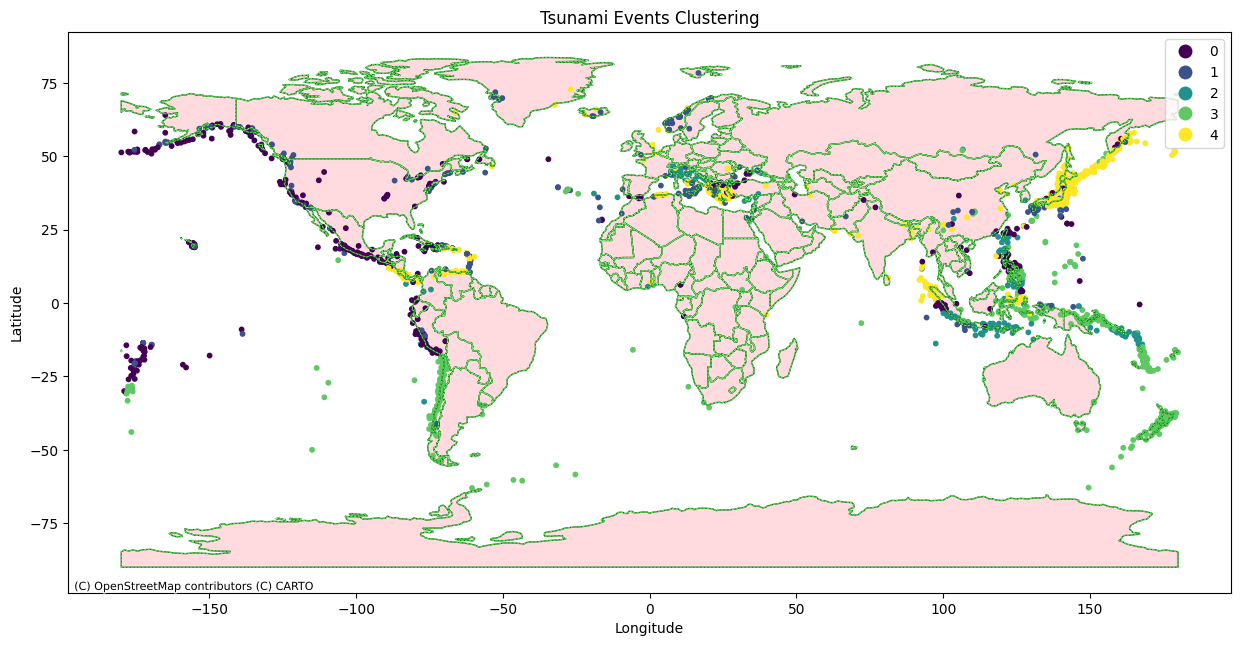

In [11]:
# Load Natural Earth features for continents and oceans
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
oceans = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plot continents
world.boundary.plot(ax=ax, linewidth=1, color='green')
world.plot(ax=ax, color='lightpink', alpha=0.5)

# Plot oceans (simplified)
oceans.boundary.plot(ax=ax, linewidth=0.5, color='lightgreen', linestyle='dashed')

# Plot tsunami clusters
gdf.plot(column='Cluster', categorical=True, legend=True, markersize=10, cmap='viridis', ax=ax)

# Use EPSG:4326 CRS for the basemap and alternative tile provider
ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.CartoDB.Positron)

plt.title('Tsunami Events Clustering')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

     Latitude  Longitude  Tsunami Cause Code  Cluster
620    36.083     -3.583                 1.0        0
627    34.400   -119.700                 1.0        0
629   -12.100    -77.100                 1.0        0
630    -9.000   -139.000                 0.0        0
639    26.000   -111.350                 3.0        0


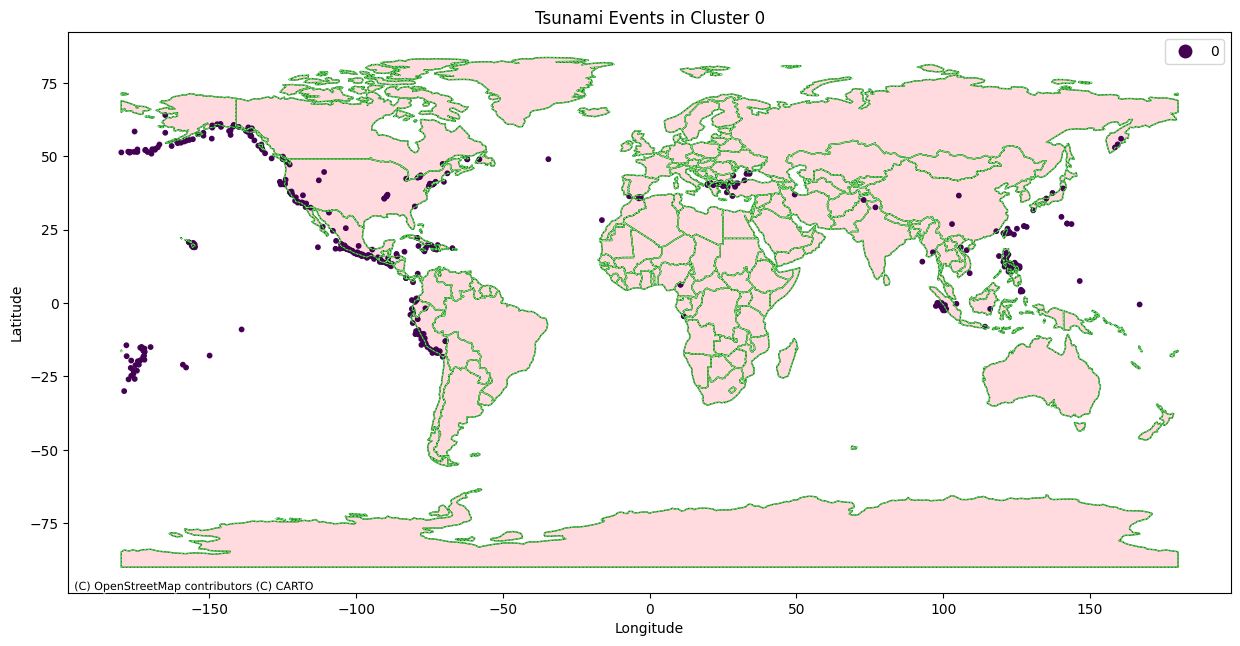

In [12]:
# Step 6: Analyzing a Specific Cluster
selected_cluster = 0  # Choose the cluster you want to analyze
cluster_data = tsunami_filtered[tsunami_filtered['Cluster'] == selected_cluster]
print(cluster_data.head())

gdf_cluster = gpd.GeoDataFrame(cluster_data, geometry=gpd.points_from_xy(cluster_data.Longitude, cluster_data.Latitude))
gdf_cluster.set_crs(epsg=4326, inplace=True)

fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plot continents
world.boundary.plot(ax=ax, linewidth=1, color='green')
world.plot(ax=ax, color='lightpink', alpha=0.5)

# Plot oceans (simplified)
oceans.boundary.plot(ax=ax, linewidth=0.5, color='lightgreen', linestyle='dashed')

# Plot tsunami clusters
gdf_cluster.plot(column='Cluster', categorical=True, legend=True, markersize=10, cmap='viridis', ax=ax)

# Use EPSG:4326 CRS for the basemap and alternative tile provider
ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.CartoDB.Positron)

plt.title(f'Tsunami Events in Cluster {selected_cluster}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

Pacific Rim, particularly along the western coast of the Americas (North and South America) and the eastern coast of Asia, which are part of the "Ring of Fire."

     Latitude  Longitude  Tsunami Cause Code  Cluster
611    45.300     14.400                 9.0        1
641    69.433     20.150                 8.0        1
653    40.817     14.433                 6.0        1
658    -8.000    115.000                 3.0        1
665    37.500     13.000                 1.0        1


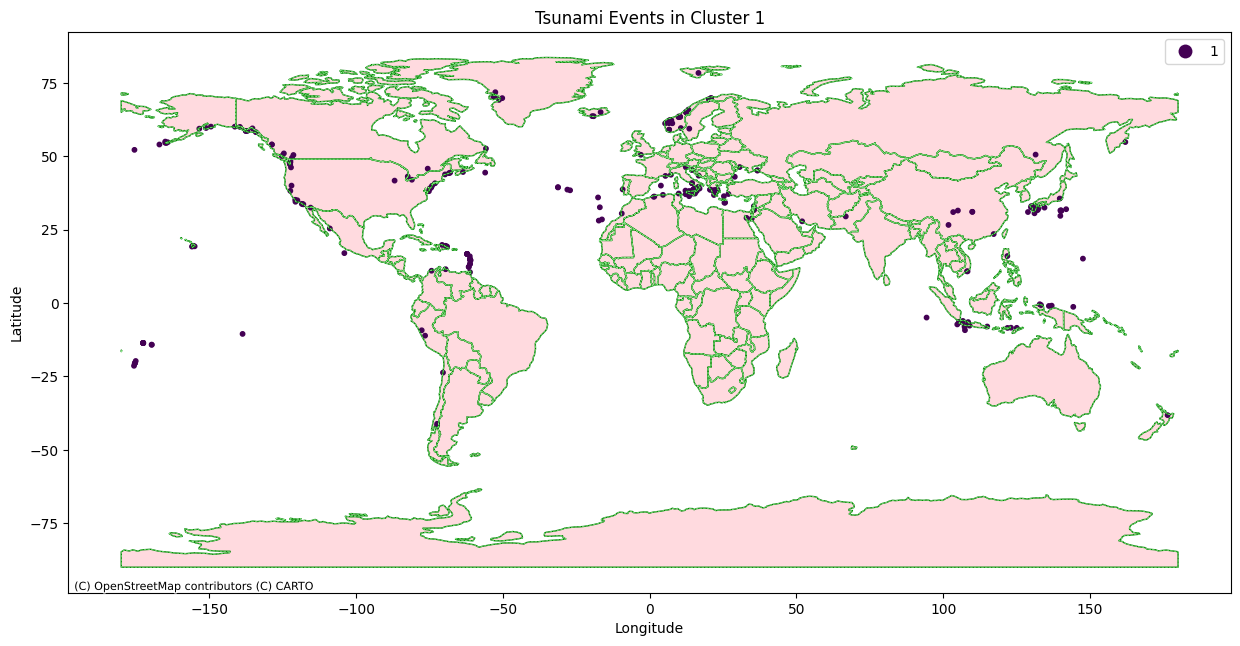

In [13]:
# Step 6: Analyzing a Specific Cluster
selected_cluster = 1  # Choose the cluster you want to analyze
cluster_data = tsunami_filtered[tsunami_filtered['Cluster'] == selected_cluster]
print(cluster_data.head())

gdf_cluster = gpd.GeoDataFrame(cluster_data, geometry=gpd.points_from_xy(cluster_data.Longitude, cluster_data.Latitude))
gdf_cluster.set_crs(epsg=4326, inplace=True)

fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plot continents
world.boundary.plot(ax=ax, linewidth=1, color='green')
world.plot(ax=ax, color='lightpink', alpha=0.5)

# Plot oceans (simplified)
oceans.boundary.plot(ax=ax, linewidth=0.5, color='lightgreen', linestyle='dashed')

# Plot tsunami clusters
gdf_cluster.plot(column='Cluster', categorical=True, legend=True, markersize=10, cmap='viridis', ax=ax)

# Use EPSG:4326 CRS for the basemap and alternative tile provider
ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.CartoDB.Positron)

plt.title(f'Tsunami Events in Cluster {selected_cluster}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

The Mediterranean region and parts of Europe, indicating seismic activity in these areas.


     Latitude  Longitude  Tsunami Cause Code  Cluster
628    41.700     12.700                 1.0        2
631    44.833      7.250                 1.0        2
634    44.800      7.200                 1.0        2
655   -10.217    123.633                 1.0        2
669    43.917      8.033                 1.0        2


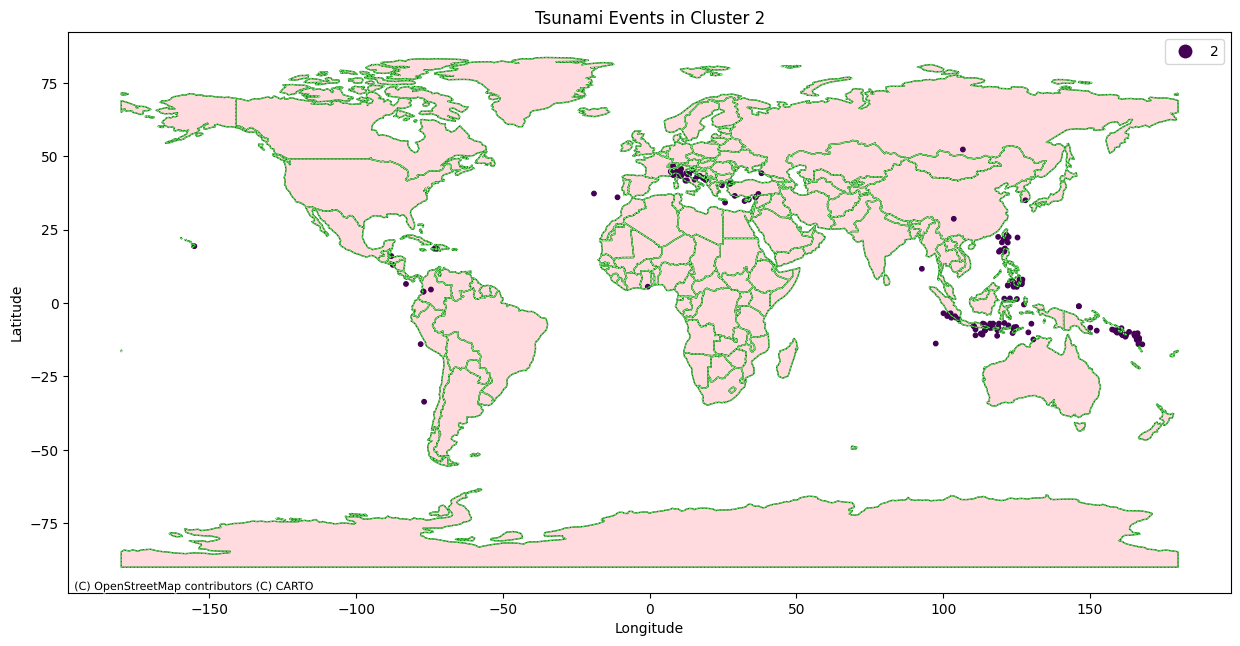

In [14]:
# Step 6: Analyzing a Specific Cluster
selected_cluster = 2  # Choose the cluster you want to analyze
cluster_data = tsunami_filtered[tsunami_filtered['Cluster'] == selected_cluster]
print(cluster_data.head())

gdf_cluster = gpd.GeoDataFrame(cluster_data, geometry=gpd.points_from_xy(cluster_data.Longitude, cluster_data.Latitude))
gdf_cluster.set_crs(epsg=4326, inplace=True)

fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plot continents
world.boundary.plot(ax=ax, linewidth=1, color='green')
world.plot(ax=ax, color='lightpink', alpha=0.5)

# Plot oceans (simplified)
oceans.boundary.plot(ax=ax, linewidth=0.5, color='lightgreen', linestyle='dashed')

# Plot tsunami clusters
gdf_cluster.plot(column='Cluster', categorical=True, legend=True, markersize=10, cmap='viridis', ax=ax)

# Use EPSG:4326 CRS for the basemap and alternative tile provider
ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.CartoDB.Positron)

plt.title(f'Tsunami Events in Cluster {selected_cluster}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

Southeast Asia: Philippines, Indonesia, and Malaysia.

     Latitude  Longitude  Tsunami Cause Code  Cluster
615     -3.70     128.20                 1.0        3
625    -29.06     167.95                 0.0        3
636    -33.88      18.45                 1.0        3
637     14.00     143.30                 1.0        3
643    -33.00     -71.40                 1.0        3


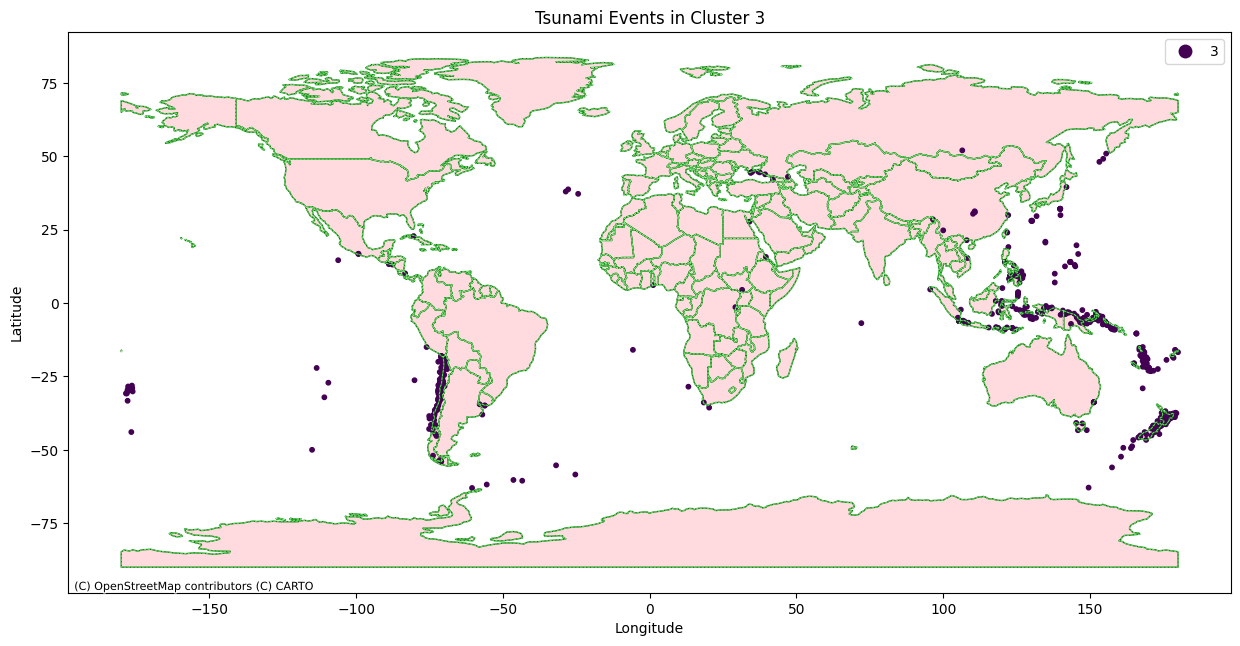

In [15]:
# Step 6: Analyzing a Specific Cluster
selected_cluster = 3  # Choose the cluster you want to analyze
cluster_data = tsunami_filtered[tsunami_filtered['Cluster'] == selected_cluster]
print(cluster_data.head())

gdf_cluster = gpd.GeoDataFrame(cluster_data, geometry=gpd.points_from_xy(cluster_data.Longitude, cluster_data.Latitude))
gdf_cluster.set_crs(epsg=4326, inplace=True)

fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plot continents
world.boundary.plot(ax=ax, linewidth=1, color='green')
world.plot(ax=ax, color='lightpink', alpha=0.5)

# Plot oceans (simplified)
oceans.boundary.plot(ax=ax, linewidth=0.5, color='lightgreen', linestyle='dashed')

# Plot tsunami clusters
gdf_cluster.plot(column='Cluster', categorical=True, legend=True, markersize=10, cmap='viridis', ax=ax)

# Use EPSG:4326 CRS for the basemap and alternative tile provider
ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.CartoDB.Positron)

plt.title(f'Tsunami Events in Cluster {selected_cluster}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

The west coast of South America, particularly around Chile and Peru, Asia-Pacific Region:  Indonesia, the Philippines, and Japan.

     Latitude  Longitude  Tsunami Cause Code  Cluster
612      17.2      -62.4                 1.0        4
614      10.3      -64.5                 1.0        4
616      45.7       26.6                 1.0        4
617      36.5        2.9                 1.0        4
618      37.7      138.3                 1.0        4


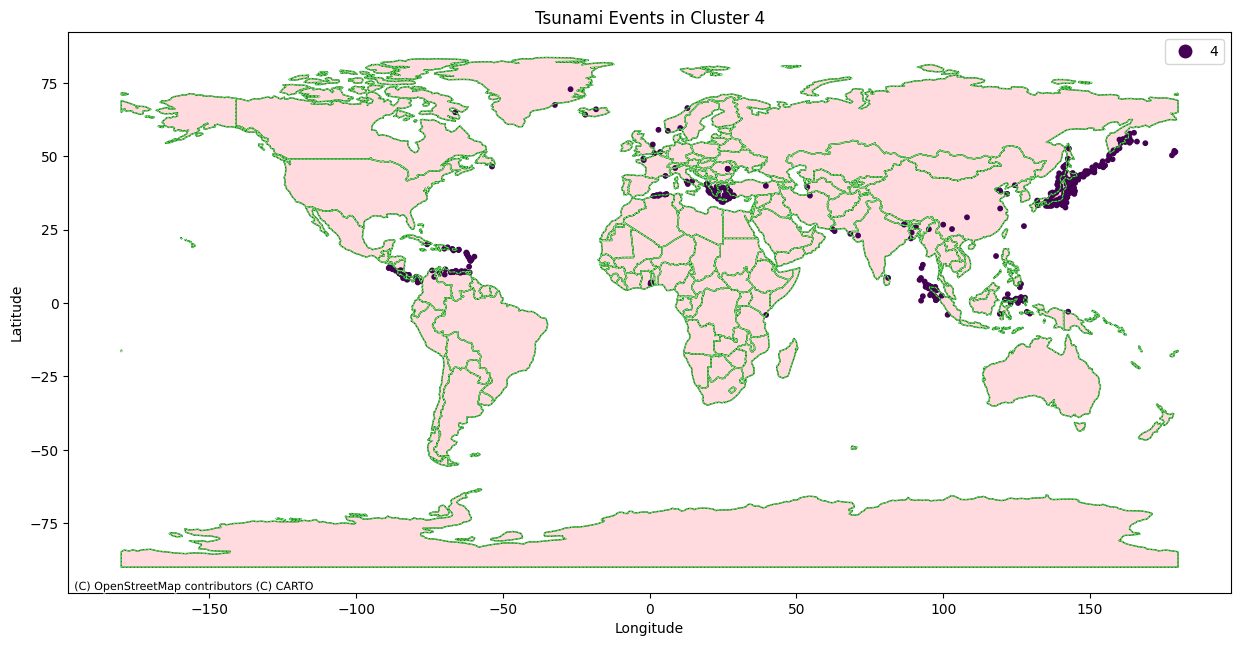

In [16]:
# Step 6: Analyzing a Specific Cluster
selected_cluster = 4  # Choose the cluster you want to analyze
cluster_data = tsunami_filtered[tsunami_filtered['Cluster'] == selected_cluster]
print(cluster_data.head())

gdf_cluster = gpd.GeoDataFrame(cluster_data, geometry=gpd.points_from_xy(cluster_data.Longitude, cluster_data.Latitude))
gdf_cluster.set_crs(epsg=4326, inplace=True)

fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plot continents
world.boundary.plot(ax=ax, linewidth=1, color='green')
world.plot(ax=ax, color='lightpink', alpha=0.5)

# Plot oceans (simplified)
oceans.boundary.plot(ax=ax, linewidth=0.5, color='lightgreen', linestyle='dashed')

# Plot tsunami clusters
gdf_cluster.plot(column='Cluster', categorical=True, legend=True, markersize=10, cmap='viridis', ax=ax)

# Use EPSG:4326 CRS for the basemap and alternative tile provider
ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.CartoDB.Positron)

plt.title(f'Tsunami Events in Cluster {selected_cluster}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

 Japan, Central America, especially along the Pacific coast.

C:\Users\ungdu\AppData\Local\Temp\ipykernel_1164\4114247782.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tsunami_country_counts.values, y=tsunami_country_counts.index, palette="magma")


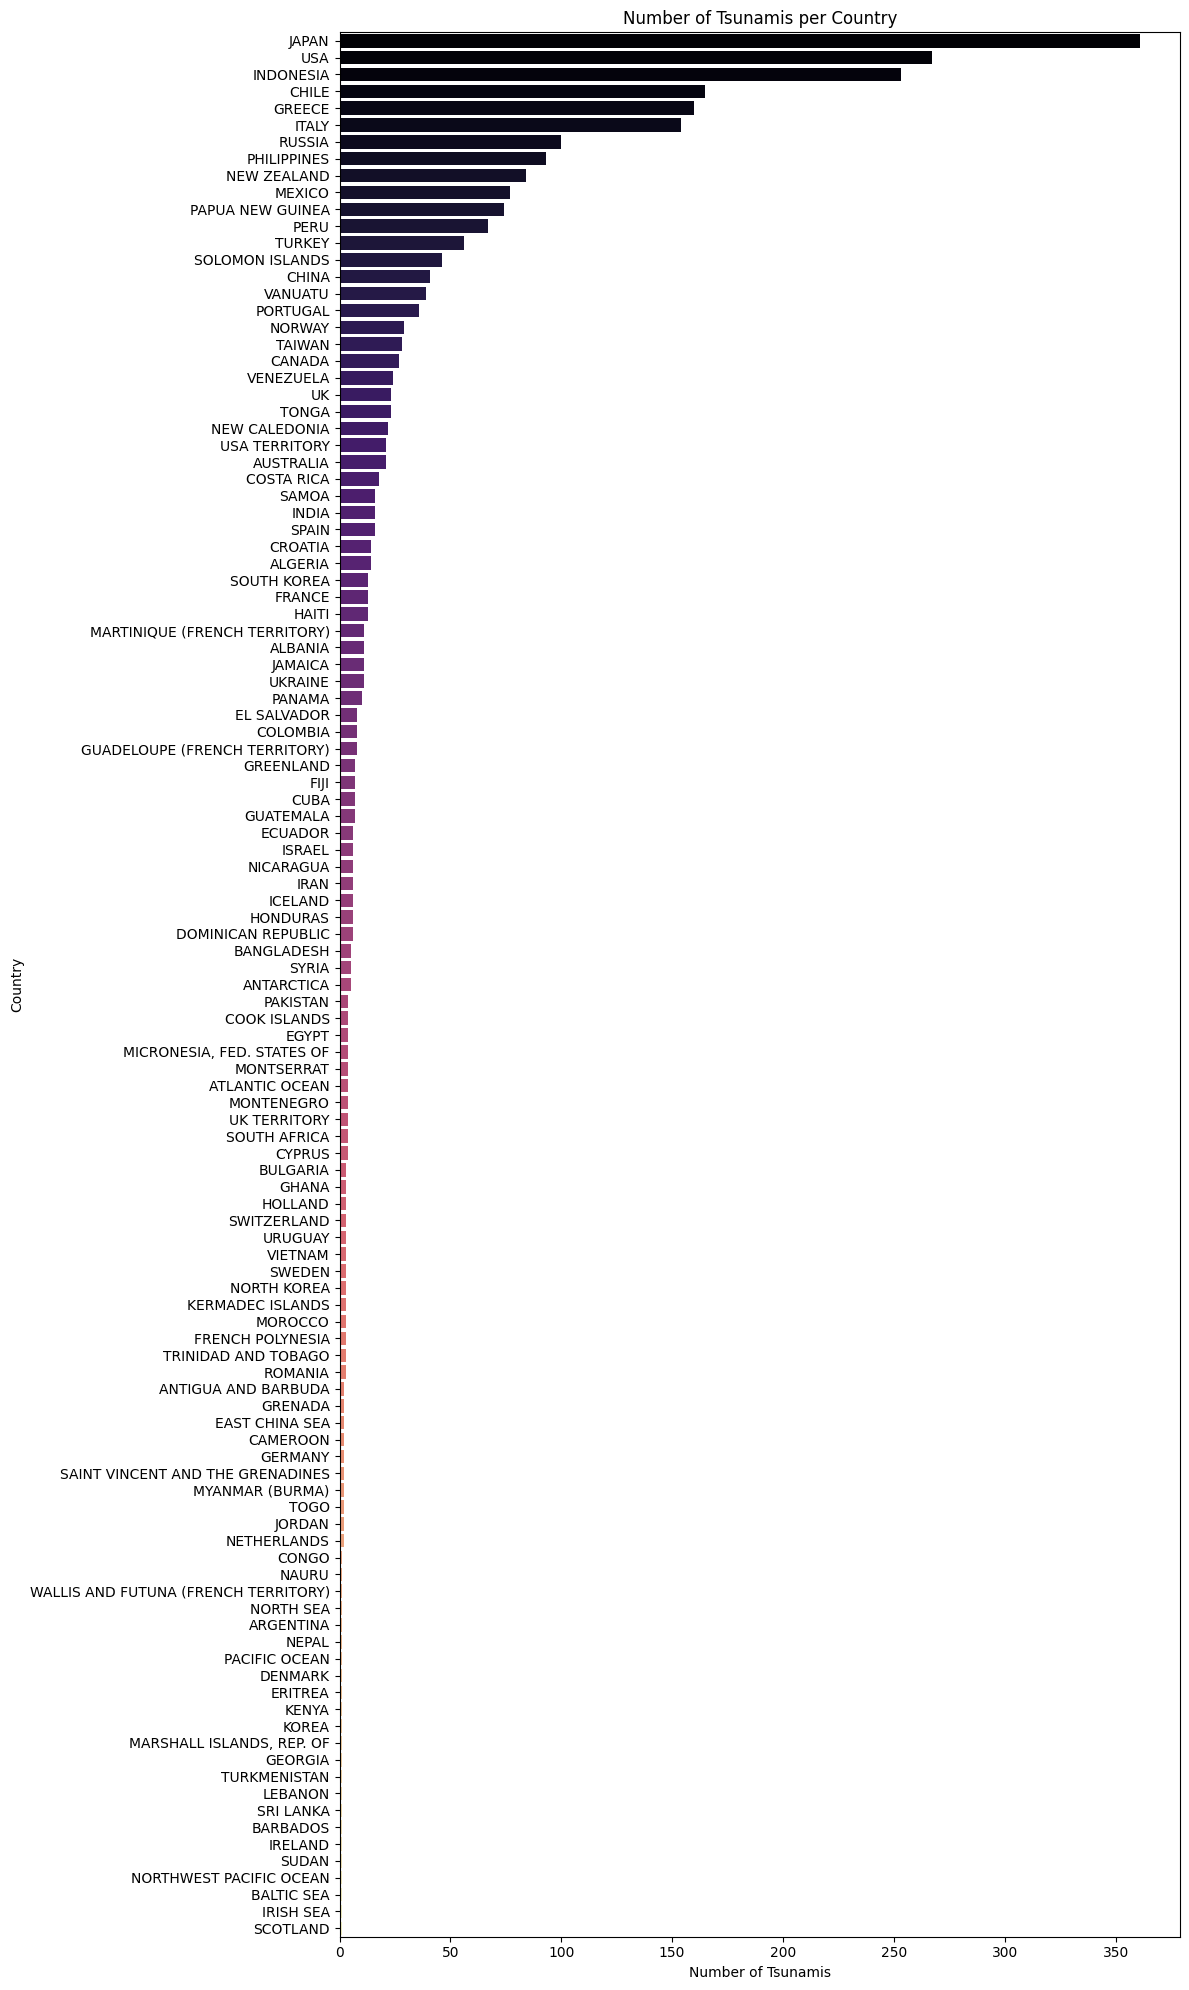

In [25]:
# Count the number of tsunamis per country
tsunami_country_counts = tsunami['Country'].value_counts()

# Create the plot
plt.figure(figsize=(12, 20))
sns.barplot(x=tsunami_country_counts.values, y=tsunami_country_counts.index, palette="magma")

# Add labels and title
plt.xlabel('Number of Tsunamis')
plt.ylabel('Country')
plt.title('Number of Tsunamis per Country')

# Adjust layout for better readability
plt.tight_layout()

# Show the plot
plt.show()

In [18]:
tsunami.dtypes

Year                                    int64
Mo                                    float64
Tsunami Event Validity                  int64
Tsunami Cause Code                    float64
Earthquake Magnitude                  float64
Vol                                   float64
Deposits                                int64
Country                                object
Location Name                          object
Latitude                              float64
Longitude                             float64
Maximum Water Height (m)              float64
Number of Runups                        int64
Tsunami Intensity                     float64
Deaths                                float64
Death Description                     float64
Damage ($Mil)                         float64
Damage Description                    float64
Houses Destroyed                      float64
Houses Destroyed Description          float64
Total Deaths                          float64
Total Death Description           

In [19]:
# Create a dictionary mapping cause codes to their descriptions
cause_code_mapping = {
    0: "Unknown",
    1: "Earthquake",
    2: "Questionable Earthquake",
    3: "Earthquake and Landslide",
    4: "Volcano and Earthquake",
    5: "Volcano, Earthquake, and Landslide",
    6: "Volcano",
    7: "Volcano and Landslide",
    8: "Landslide",
    9: "Meteorological",
    10: "Explosion",
    11: "Astronomical Tide"
}

# Replace the numerical values with the descriptive values
tsunami['Tsunami Cause Code'] = tsunami['Tsunami Cause Code'].replace(cause_code_mapping)

# Verify the change
print(tsunami['Tsunami Cause Code'].head())


0    Earthquake
1       Volcano
2    Earthquake
3       Unknown
4       Unknown
Name: Tsunami Cause Code, dtype: object


C:\Users\ungdu\AppData\Local\Temp\ipykernel_1164\2986489040.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tsunami_cause_counts.values, y=tsunami_cause_counts.index, palette="magma")


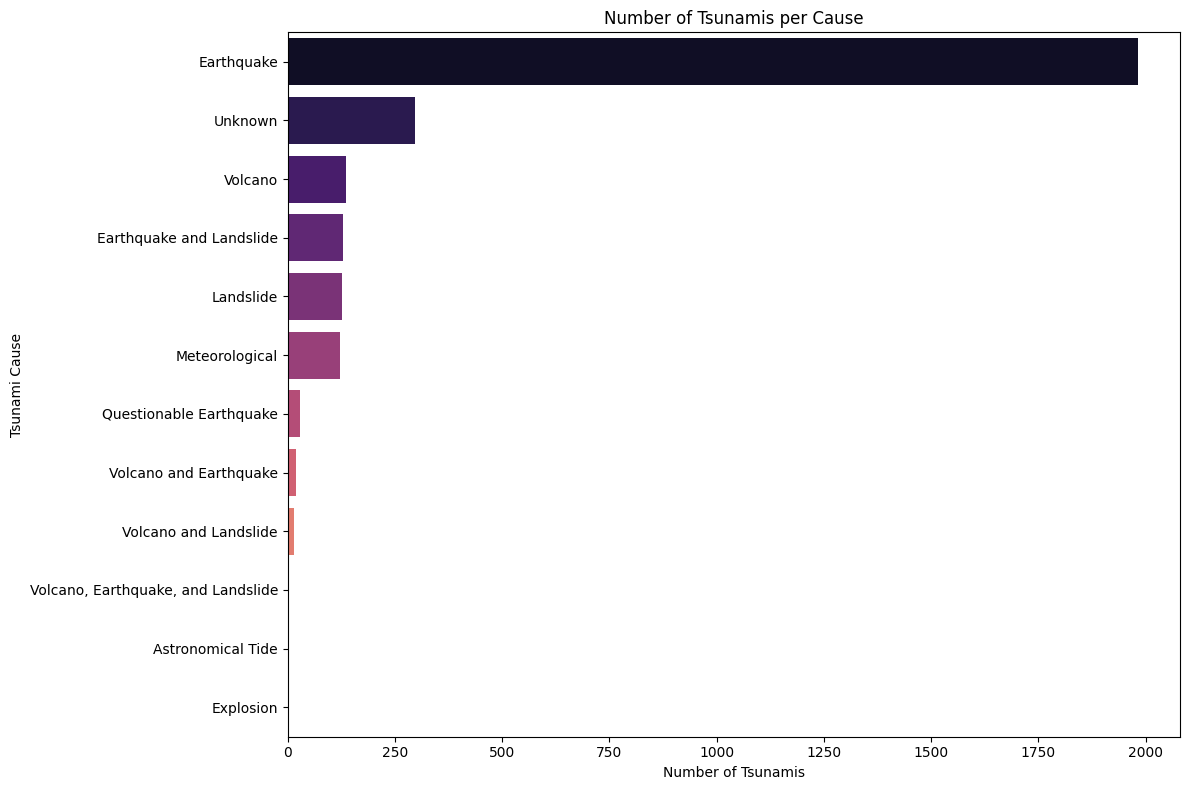

In [20]:

# Count the number of tsunamis per cause
tsunami_cause_counts = tsunami['Tsunami Cause Code'].value_counts()

# Create the plot
plt.figure(figsize=(12, 8))
sns.barplot(x=tsunami_cause_counts.values, y=tsunami_cause_counts.index, palette="magma")

# Add labels and title
plt.xlabel('Number of Tsunamis')
plt.ylabel('Tsunami Cause')
plt.title('Number of Tsunamis per Cause')

# Adjust layout for better readability
plt.tight_layout()

# Show the plot
plt.show()

In [26]:
# Drop rows with missing 'Mo' values
tsunami = tsunami.dropna(subset=['Mo'])

# Convert the 'Mo' column to integer
tsunami['Mo'] = tsunami['Mo'].astype(int)

# Create a dictionary mapping month numbers to month names
month_mapping = {
    1: "January", 2: "February", 3: "March", 4: "April",
    5: "May", 6: "June", 7: "July", 8: "August",
    9: "September", 10: "October", 11: "November", 12: "December"
}

# Replace the month numbers with the month names
tsunami['Month Name'] = tsunami['Mo'].replace(month_mapping)

# Count the number of tsunamis per month
tsunami_month_counts = tsunami['Month Name'].value_counts()

# Sort the counts from highest to lowest
tsunami_month_counts = tsunami_month_counts.sort_values(ascending=False)

C:\Users\ungdu\AppData\Local\Temp\ipykernel_1164\2082088706.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tsunami_month_counts.values, y=tsunami_month_counts.index, palette="magma")


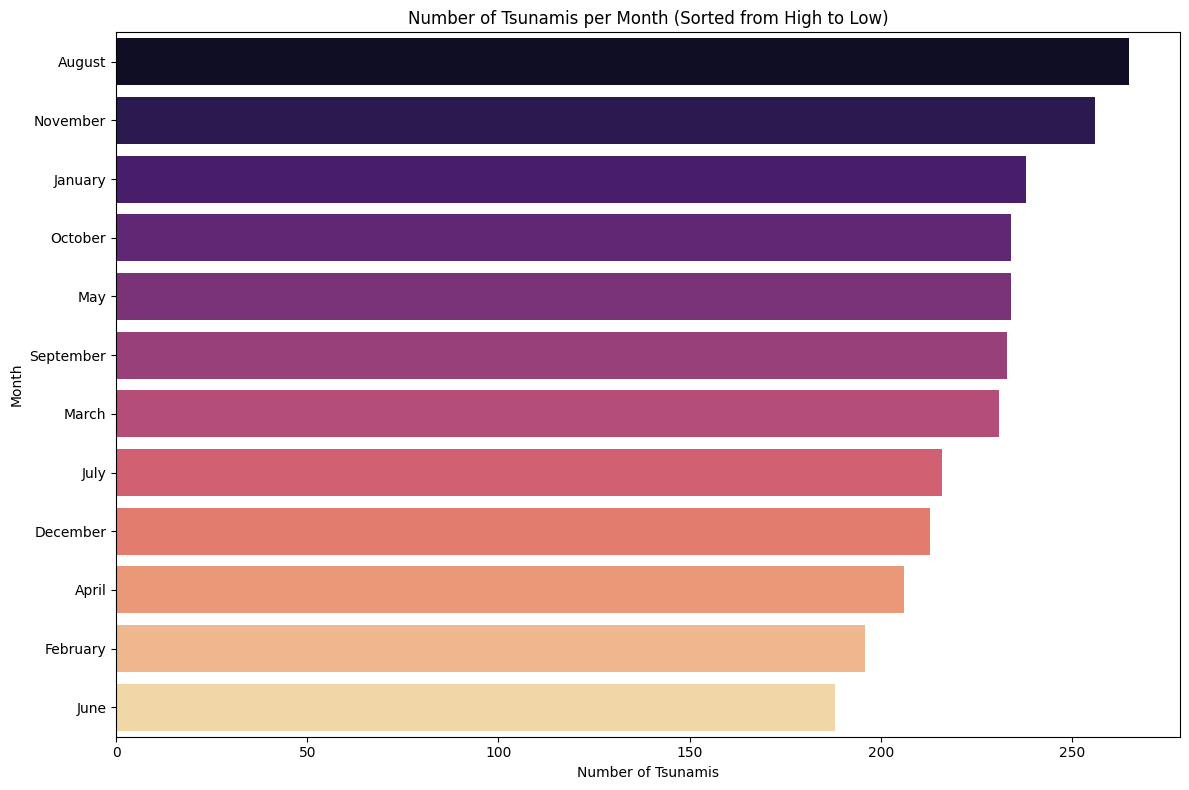

In [27]:
# Create the plot
plt.figure(figsize=(12, 8))
sns.barplot(x=tsunami_month_counts.values, y=tsunami_month_counts.index, palette="magma")

# Add labels and title
plt.xlabel('Number of Tsunamis')
plt.ylabel('Month')
plt.title('Number of Tsunamis per Month (Sorted from High to Low)')

# Adjust layout for better readability
plt.tight_layout()

# Show the plot
plt.show()

C:\Users\ungdu\AppData\Local\Temp\ipykernel_1164\1374237524.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=magnitude_counts.index, y=magnitude_counts.values, palette="magma")


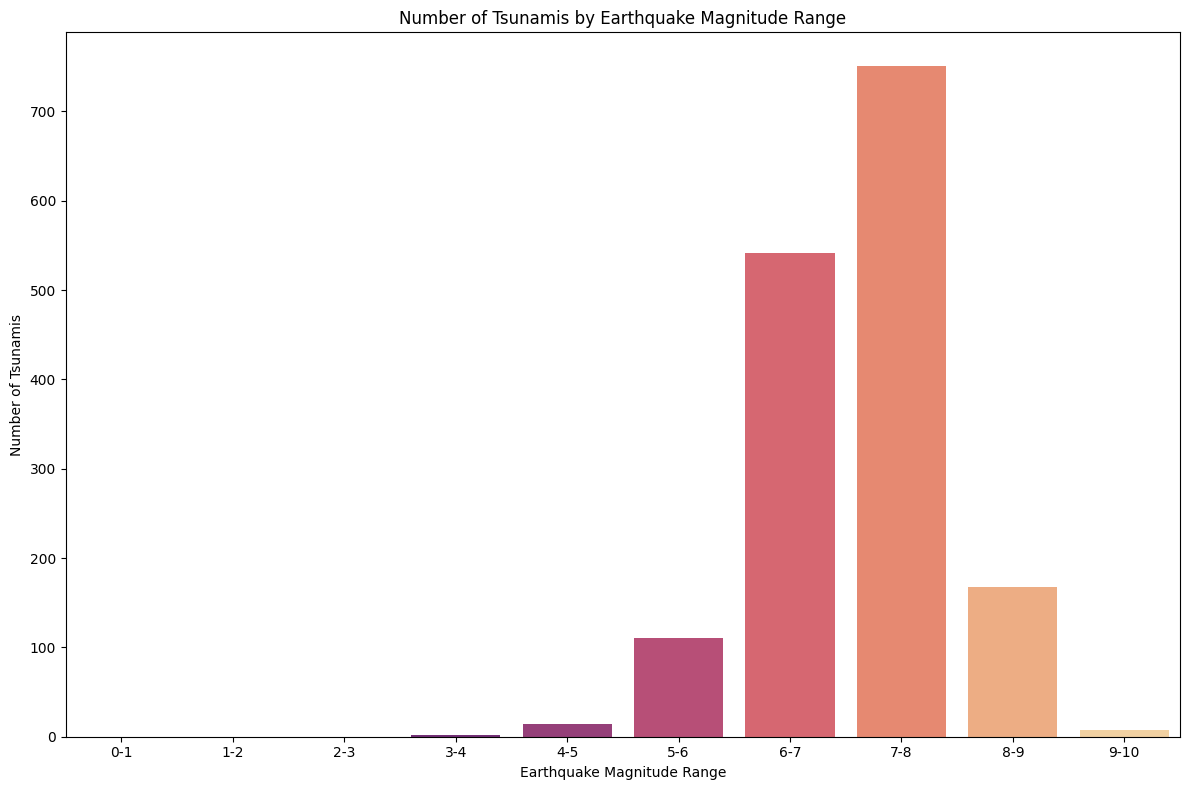

In [34]:
# Create bins for earthquake magnitudes
bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
labels = ['0-1', '1-2', '2-3', '3-4', '4-5', '5-6', '6-7', '7-8', '8-9', '9-10']
tsunami['Magnitude Bin'] = pd.cut(tsunami['Earthquake Magnitude'], bins=bins, labels=labels, right=False)

# Count the number of tsunamis in each bin
magnitude_counts = tsunami['Magnitude Bin'].value_counts().sort_index()

# Create the bar plot
plt.figure(figsize=(12, 8))
sns.barplot(x=magnitude_counts.index, y=magnitude_counts.values, palette="magma")

# Add labels and title
plt.xlabel('Earthquake Magnitude Range')
plt.ylabel('Number of Tsunamis')
plt.title('Number of Tsunamis by Earthquake Magnitude Range')

# Adjust layout for better readability
plt.tight_layout()

# Show the plot
plt.show()

C:\Users\ungdu\AppData\Local\Temp\ipykernel_1164\813505083.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=height_counts.index, y=height_counts.values, palette="magma")


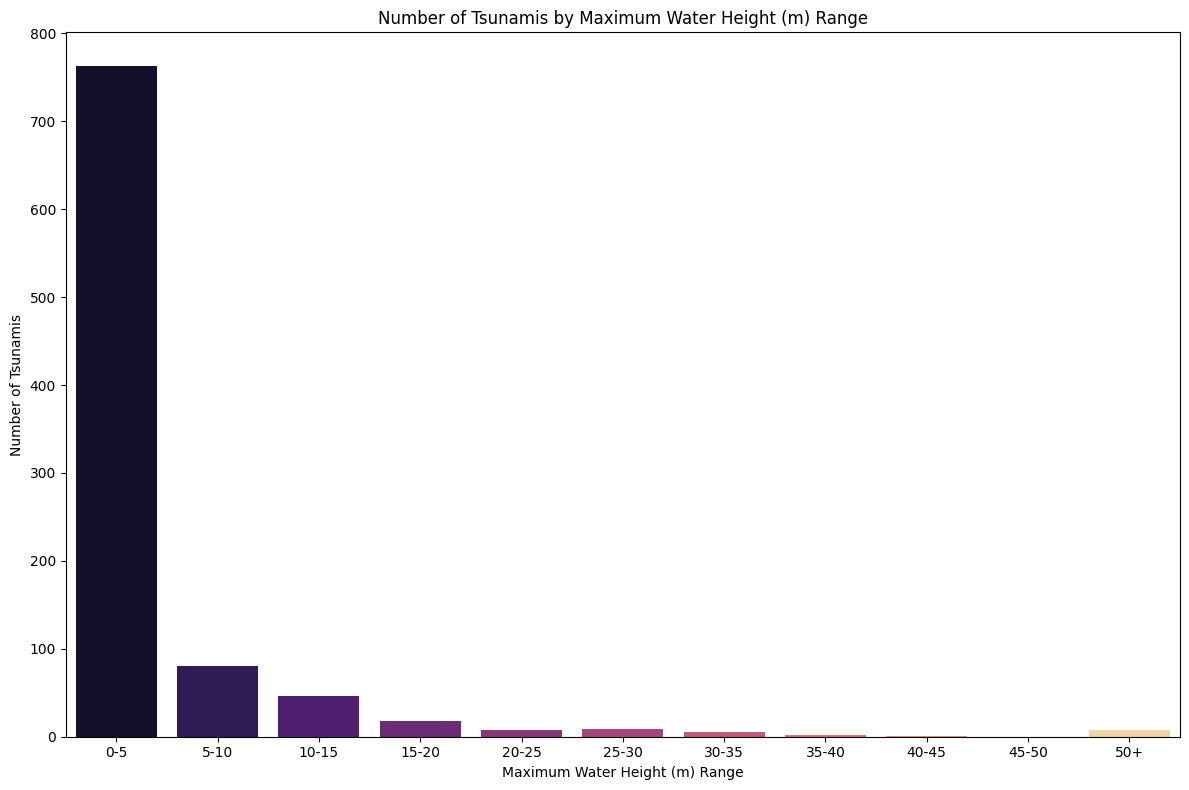

In [36]:
# Create bins for maximum water height
bins = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 100]
labels = ['0-5', '5-10', '10-15', '15-20', '20-25', '25-30', '30-35', '35-40', '40-45', '45-50', '50+']
tsunami['Height Bin'] = pd.cut(tsunami['Maximum Water Height (m)'], bins=bins, labels=labels, right=False)

# Count the number of tsunamis in each bin
height_counts = tsunami['Height Bin'].value_counts().sort_index()

# Create the bar plot
plt.figure(figsize=(12, 8))
sns.barplot(x=height_counts.index, y=height_counts.values, palette="magma")

# Add labels and title
plt.xlabel('Maximum Water Height (m) Range')
plt.ylabel('Number of Tsunamis')
plt.title('Number of Tsunamis by Maximum Water Height (m) Range')

# Adjust layout for better readability
plt.tight_layout()

C:\Users\ungdu\AppData\Local\Temp\ipykernel_1164\2381310723.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=runups_counts.index, y=runups_counts.values, palette="magma")


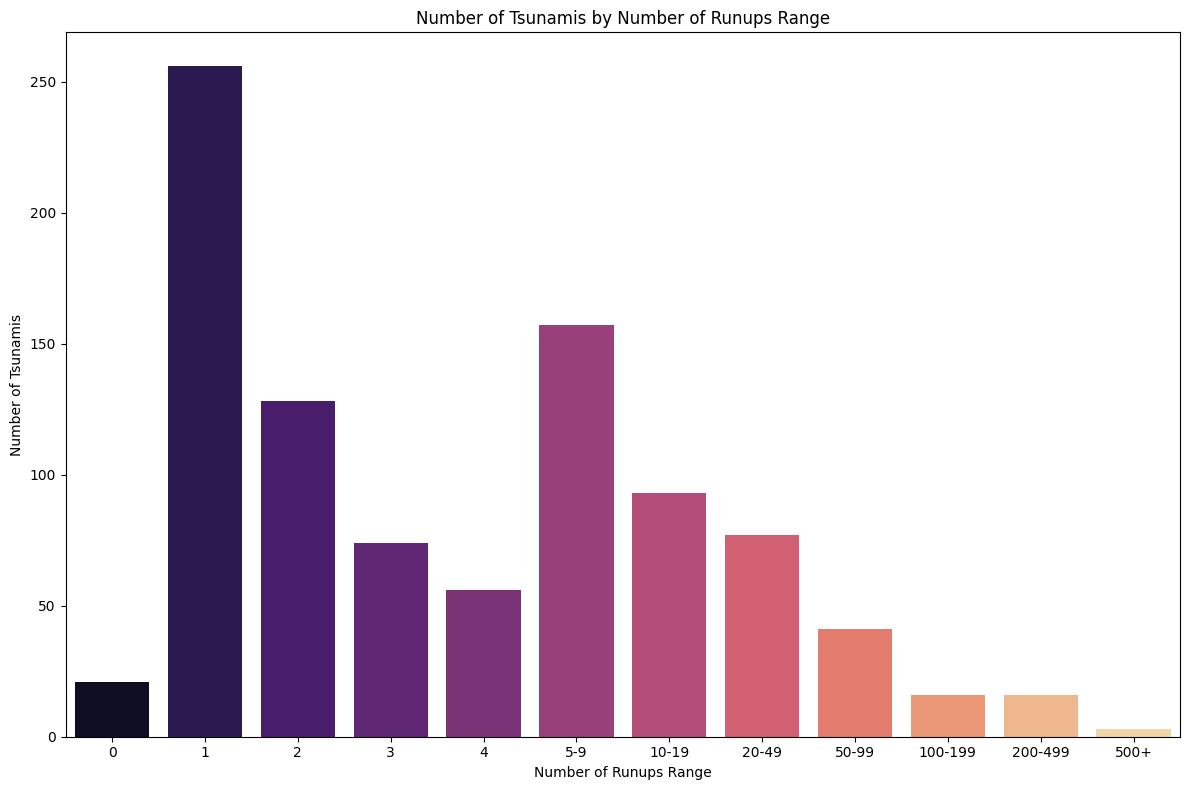

In [40]:
# Drop rows with missing 'Number of Runups' values
tsunami = tsunami.dropna(subset=['Number of Runups'])

# Create bins for number of runups
bins = [0, 1, 2, 3, 4, 5, 10, 20, 50, 100, 200, 500, 1000]
labels = ['0', '1', '2', '3', '4', '5-9', '10-19', '20-49', '50-99', '100-199', '200-499', '500+']
tsunami['Runups Bin'] = pd.cut(tsunami['Number of Runups'], bins=bins, labels=labels, right=False)

# Count the number of tsunamis in each bin
runups_counts = tsunami['Runups Bin'].value_counts().sort_index()

# Create the bar plot
plt.figure(figsize=(12, 8))
sns.barplot(x=runups_counts.index, y=runups_counts.values, palette="magma")

# Add labels and title
plt.xlabel('Number of Runups Range')
plt.ylabel('Number of Tsunamis')
plt.title('Number of Tsunamis by Number of Runups Range')

# Adjust layout for better readability
plt.tight_layout()

# Show the plot
plt.show()

In [37]:
# Create a dictionary mapping validity ratings to their descriptions
validity_mapping = {
    -1: "Erroneous Entry",
    0: "Seiche or Inland Disturbance",
    1: "Very Doubtful Tsunami",
    2: "Questionable Tsunami",
    3: "Probable Tsunami",
    4: "Definite Tsunami"
}

# Replace the numerical values with the descriptive values
tsunami['Event Validity Description'] = tsunami['Tsunami Event Validity'].replace(validity_mapping)

# Count the number of tsunamis for each validity rating
validity_counts = tsunami['Event Validity Description'].value_counts().sort_index()

C:\Users\ungdu\AppData\Local\Temp\ipykernel_1164\755040714.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=validity_counts.values, y=validity_counts.index, palette="magma")


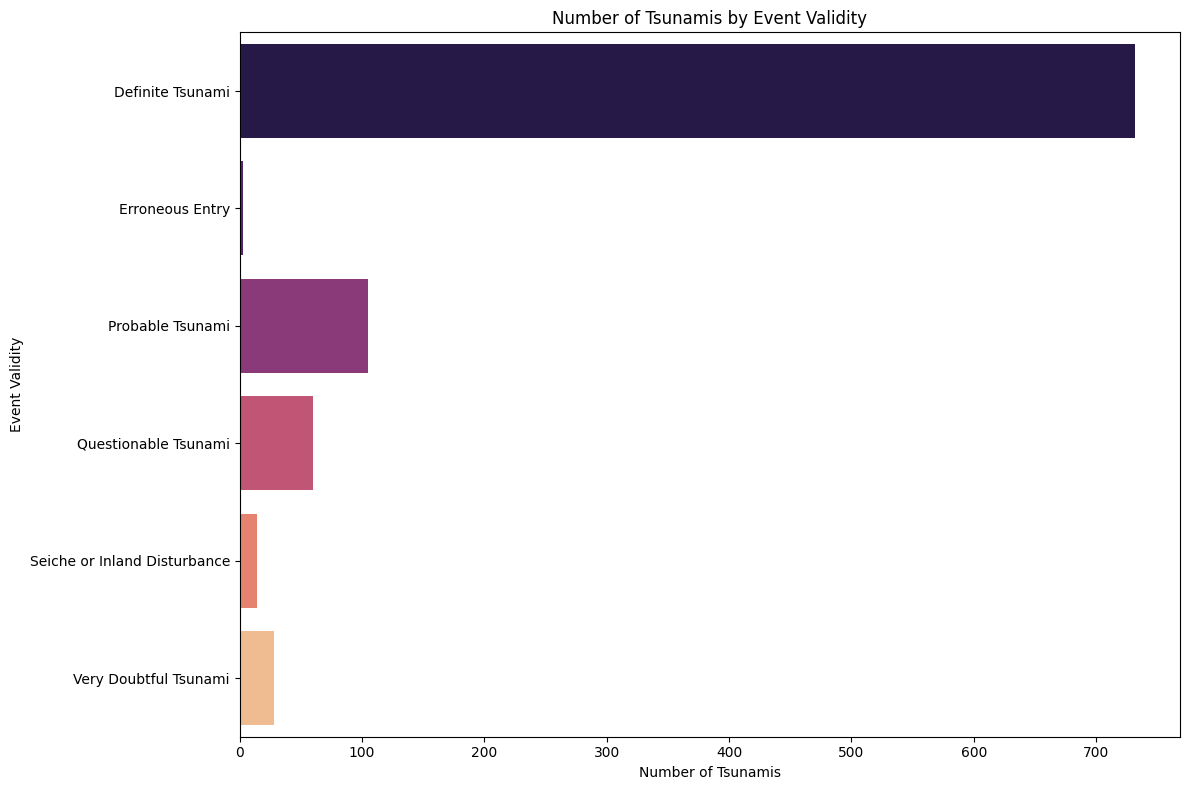

In [38]:
# Create the bar plot
plt.figure(figsize=(12, 8))
sns.barplot(x=validity_counts.values, y=validity_counts.index, palette="magma")

# Add labels and title
plt.xlabel('Number of Tsunamis')
plt.ylabel('Event Validity')
plt.title('Number of Tsunamis by Event Validity')

# Adjust layout for better readability
plt.tight_layout()

# Show the plot
plt.show()

In [41]:
# Create a dictionary mapping death descriptions to their meanings
death_description_mapping = {
    0: "None",
    1: "Few (~1 to 50 deaths)",
    2: "Some (~51 to 100 deaths)",
    3: "Many (~101 to 1000 deaths)",
    4: "Very many (over 1000 deaths)"
}

# Replace the numerical values with the descriptive values
tsunami['Total Death Description'] = tsunami['Total Death Description'].replace(death_description_mapping)

# Count the number of tsunamis for each death description
death_description_counts = tsunami['Total Death Description'].value_counts().sort_index()

C:\Users\ungdu\AppData\Local\Temp\ipykernel_1164\999324988.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=death_description_counts.values, y=death_description_counts.index, palette="magma")


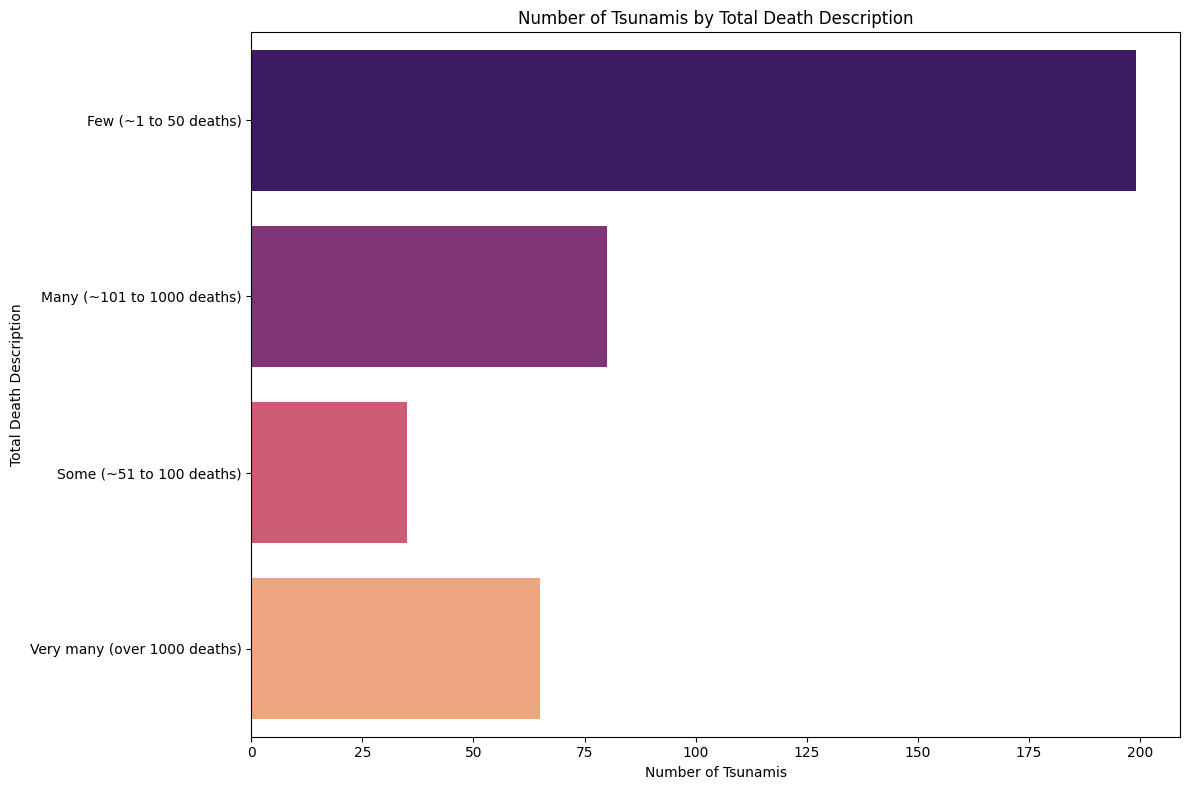

In [42]:
# Create the bar plot
plt.figure(figsize=(12, 8))
sns.barplot(x=death_description_counts.values, y=death_description_counts.index, palette="magma")

# Add labels and title
plt.xlabel('Number of Tsunamis')
plt.ylabel('Total Death Description')
plt.title('Number of Tsunamis by Total Death Description')

# Adjust layout for better readability
plt.tight_layout()

# Show the plot
plt.show()

In [44]:
# Create a dictionary mapping damage descriptions to their meanings
damage_description_mapping = {
    0: "NONE",
    1: "LIMITED (less than $1 million)",
    2: "MODERATE (~$1 to $5 million)",
    3: "SEVERE (~$5 to $25 million)",
    4: "EXTREME (~$25 million or more)"
}

# Replace the numerical values with the descriptive values
tsunami['Total Damage Description'] = tsunami['Total Damage Description'].replace(damage_description_mapping)

# Count the number of tsunamis for each damage description
damage_description_counts = tsunami['Total Damage Description'].value_counts().sort_index()

C:\Users\ungdu\AppData\Local\Temp\ipykernel_1164\860440242.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=damage_description_counts.values, y=damage_description_counts.index, palette="magma")


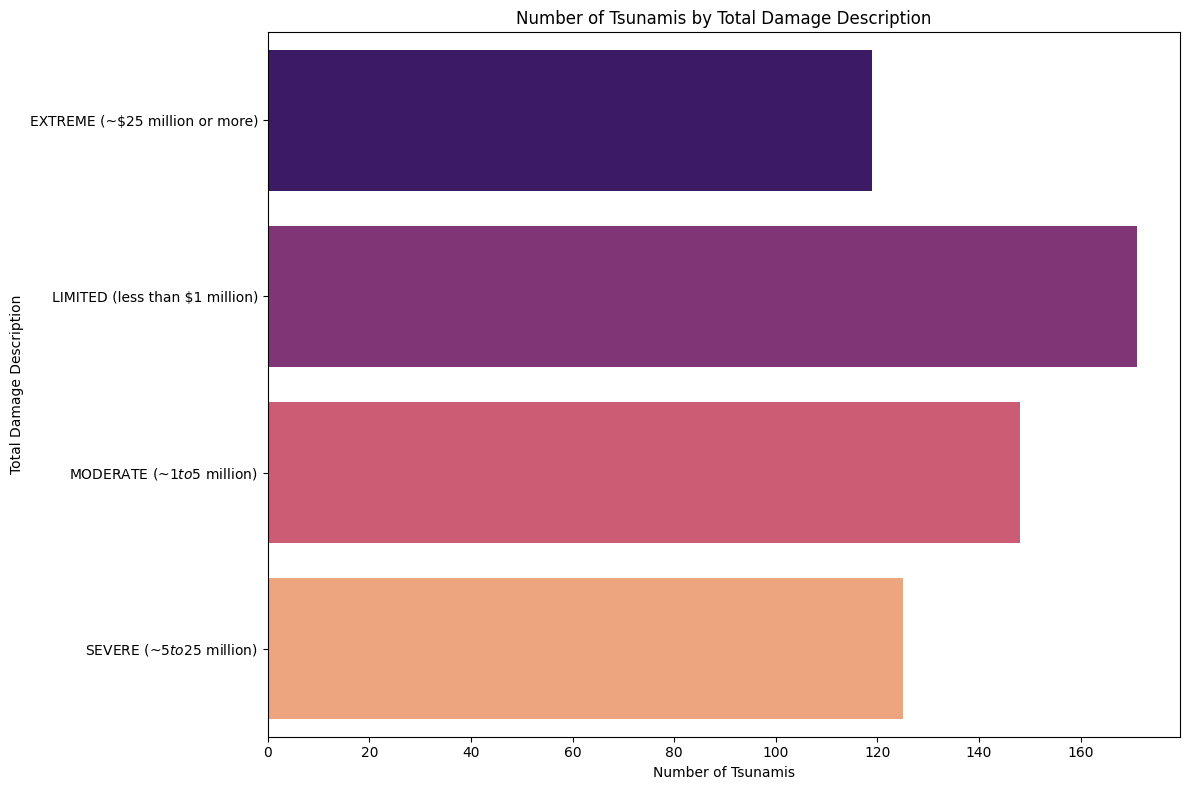

In [45]:
# Create the bar plot
plt.figure(figsize=(12, 8))
sns.barplot(x=damage_description_counts.values, y=damage_description_counts.index, palette="magma")

# Add labels and title
plt.xlabel('Number of Tsunamis')
plt.ylabel('Total Damage Description')
plt.title('Number of Tsunamis by Total Damage Description')

# Adjust layout for better readability
plt.tight_layout()

# Show the plot
plt.show()